<h1><center><B><font color = 'dark blue'> Speech Emotion Recognition </b></font></center></h1>

<h2><b><font color = 'darkblue'>Imports </b></h2>

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import random

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import to_categorical

from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


<h2><b><font color = 'darkblue'>Download datasets and reformat them</b></h2>

In [ ]:

RAVDESS = "/content/drive/MyDrive/dataset/Ravdess/"

<h2><b><font color = 'darkblue'>1- RAVDESS </b></h2>

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_happy          96
male_sad            96
male_angry          96
male_fear           96
male_surprise       96
male_disgust        96
female_happy        96
female_angry        96
female_sad          96
female_fear         96
female_disgust      96
female_surprise     96
Name: labels, dtype: int64

<h2><b><font color = 'darkblue'>Merge all datasets together</b></h2>

In [ ]:
# merge all data frames together
data_path = pd.concat([Ravdess_df], axis = 0)

# save the data frame and make index=False because we will have 4 records for each index
data_path.to_csv("new_data_path.csv",index=False)
print(len(data_path))
data_path.head()

1440


,labels,source,path
0,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
1,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
2,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
3,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
4,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...


In [ ]:
# read data frame and make sure that each index has one record not 4
data_path = pd.read_csv('/content/new_data_path.csv')
data_path

,labels,source,path
0,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
1,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
2,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
3,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
4,male_neutral,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_0...
...,...,...,...
1435,female_surprise,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_2...
1436,female_disgust,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_2...
1437,female_disgust,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_2...
1438,female_disgust,RAVDESS,/content/drive/MyDrive/dataset/Ravdess/Actor_2...


<h2><b><font color = 'darkblue'>Exploratory Data Analysis</b></h2>

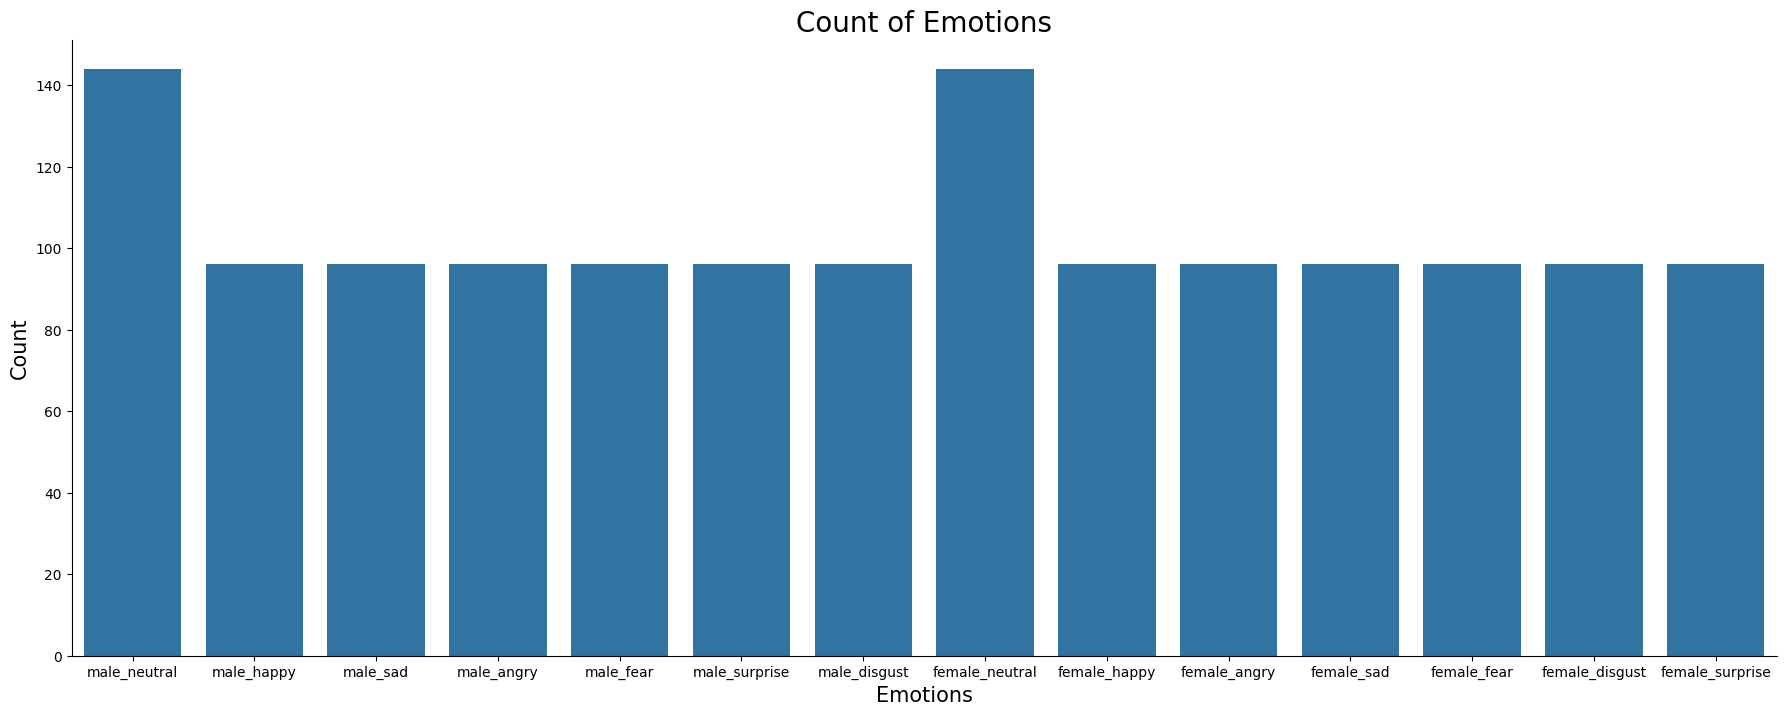

In [ ]:
plt.figure(figsize=(22,8))
sns.countplot(x=data_path.labels)
plt.ylabel('Count', size=15)
plt.xlabel('Emotions', size=15)
plt.title('Count of Emotions', size=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

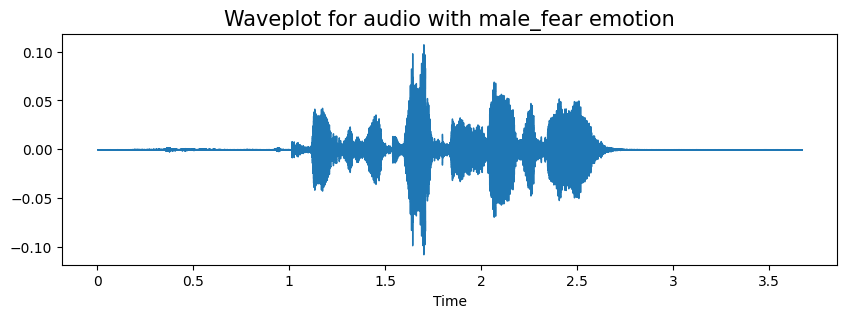

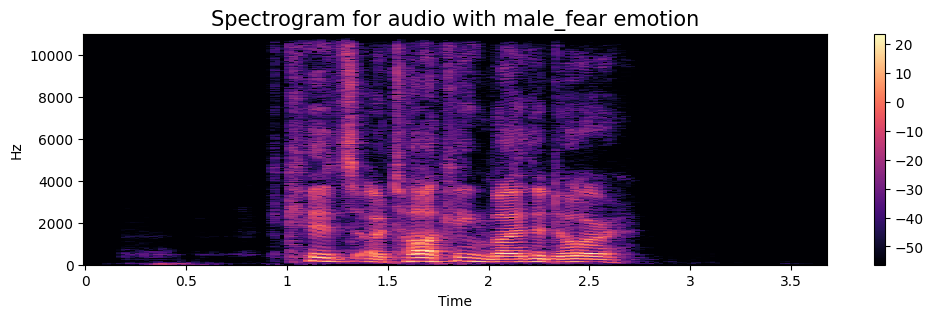

In [ ]:
emotion='male_fear'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

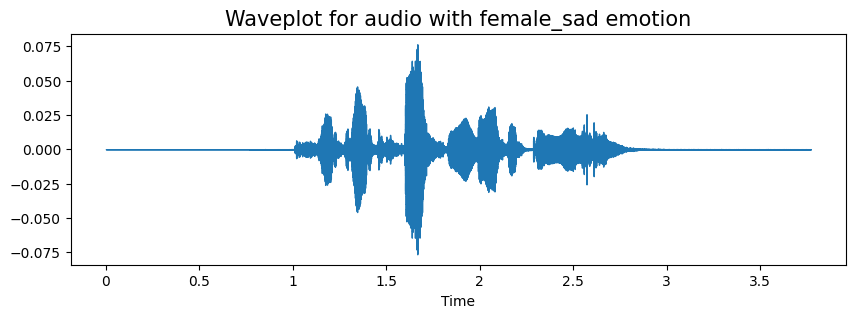

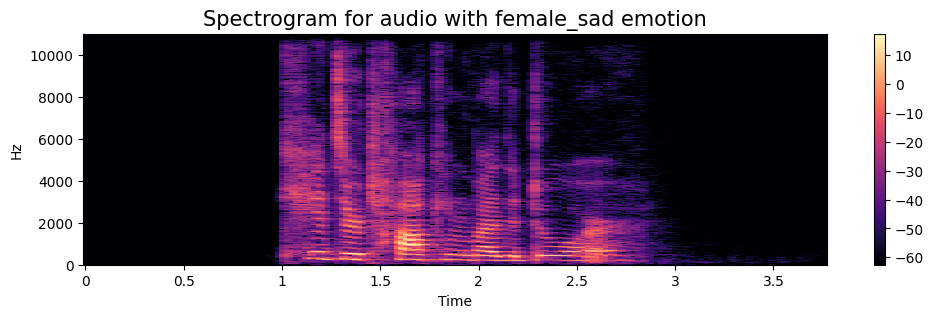

In [ ]:
emotion='female_sad'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

<h2><b><font color = 'darkblue'>Data Augmentation</b></h2>

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.70):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def higher_speed(data, speed_factor = 1.25):
    return librosa.effects.time_stretch(data,rate=speed_factor)

def lower_speed(data, speed_factor = 0.75):
    return librosa.effects.time_stretch(data,rate=speed_factor)


In [ ]:
def _plot_signal_and_augmented_signal(signal, augmented_signal, sr):
    fig, ax = plt.subplots(nrows=2)
    librosa.display.waveshow(signal, sr=sr, ax=ax[0])
    ax[0].set(title='Original Signal')
    librosa.display.waveshow(augmented_signal, sr=sr, ax=ax[1])
    ax[1].set(title='Augmented Signal')
    plt.show()

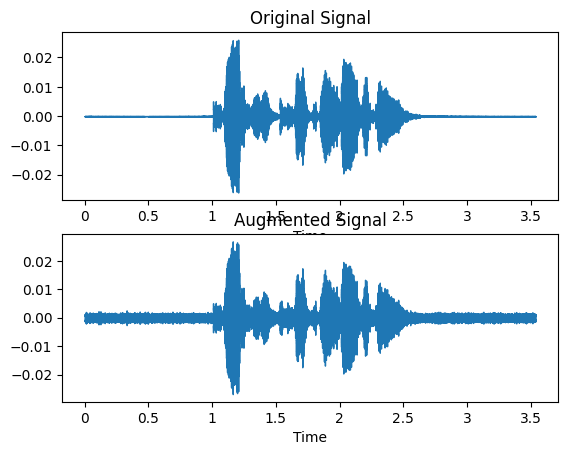

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = noise(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

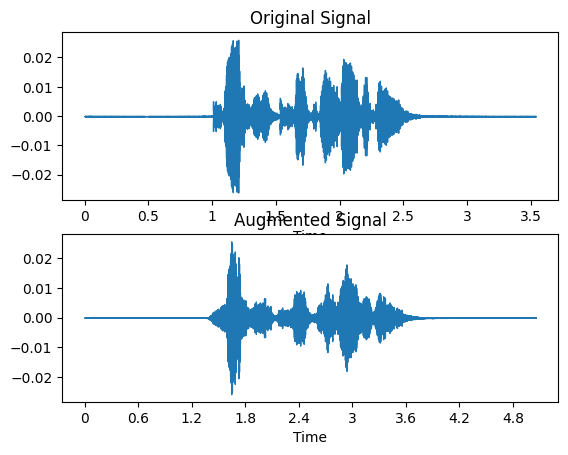

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = stretch(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

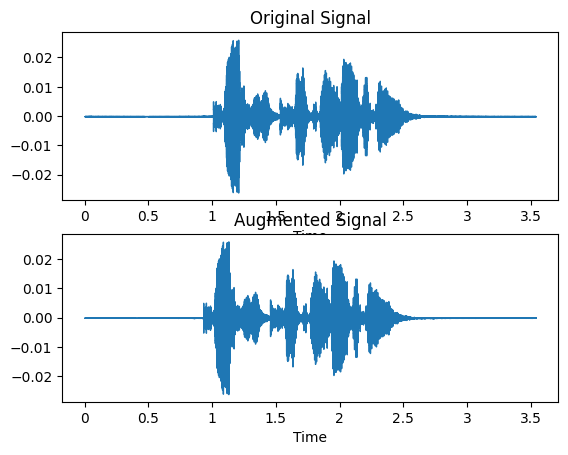

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = shift(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

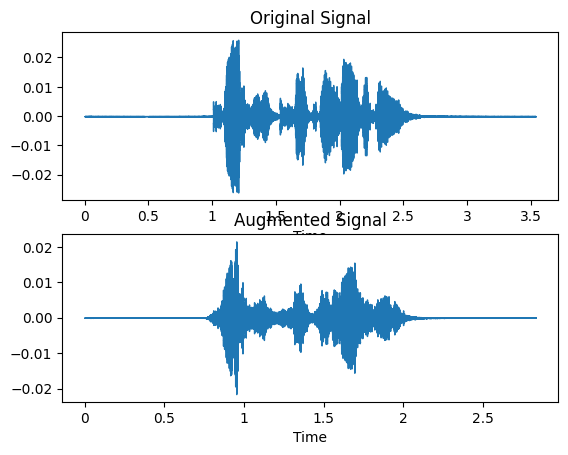

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = higher_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

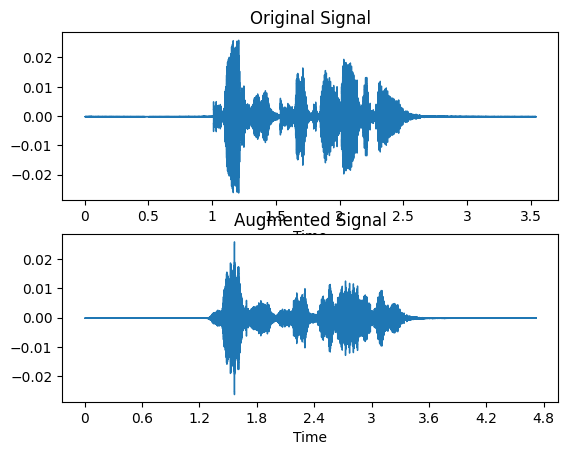

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = lower_speed(data)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

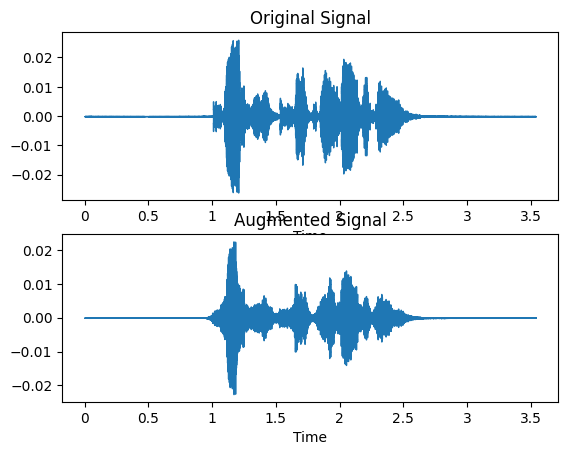

In [ ]:
path = np.array(data_path.path)[1]
data, sr = librosa.load(path)
augmented_signal = pitch(data,22050)
_plot_signal_and_augmented_signal(data, augmented_signal, sr)

In [ ]:
Audio(data, rate=sr)

In [ ]:
Audio(noise(data), rate=sr)

In [ ]:
Audio(shift(data), rate=sr)

In [ ]:
Audio(stretch(data), rate=sr)

In [ ]:
Audio(lower_speed(data), rate=sr)

In [ ]:
Audio(higher_speed(data), rate=sr)

In [ ]:
Audio(pitch(data,22050), rate=sr)

<h1><B><font color = 'darkblue'> Feature Extraction </b></font></h1>

Since I've already outlined the various types of features here, I'll just simplify things here and just use MFCC, because its the best feature for this particular problem

<h2><B><font color = 'darkblue'> - MFCC </b></font></h2>
MFCC is well known to be a good feature. And there's many ways you can slice and dice this one feature. But what is MFCC? It stands for Mel-frequency cepstral coefficient, and it is a good "representation" of the vocal tract that produces the sound. Think of it like an x-ray of your mouth

This post has a good deep dive into the MFCC should you wish to. The most common machine learning application treats the MFCC itself as an 'image' and becomes a feature. The benefit of treating it as an image is that it provides more information, and gives one the ability to draw on transfer learning. This is certainly legit and yields good accuracy. However, research has also shown that statistics relating to MFCCs (or any other time or frequency domain) can carry good amount of information as well. We'll be investigating both of this methods

In [ ]:
#sample_rate = 22050

def extract_features(data):

    result = np.array([])

    mfccs = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=58)
    mfccs_processed = np.mean(mfccs.T,axis=0)
    result = np.array(mfccs_processed)

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=3, offset=0.5)

    #without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    #noised
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    #stretched
    stretch_data = stretch(data)
    res3 = extract_features(stretch_data)
    result = np.vstack((result, res3))

    #shifted
    shift_data = shift(data)
    res4 = extract_features(shift_data)
    result = np.vstack((result, res4))

    #pitched
    pitch_data = pitch(data, sample_rate)
    res5 = extract_features(pitch_data)
    result = np.vstack((result, res5))

    #speed up
    higher_speed_data = higher_speed(data)
    res6 = extract_features(higher_speed_data)
    result = np.vstack((result, res6))

    #speed down
    lower_speed_data = higher_speed(data)
    res7 = extract_features(lower_speed_data)
    result = np.vstack((result, res7))

    return result

In [ ]:
X, Y = [], []

for path, emotion in zip(data_path.path, data_path.labels):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        # appending emotion 5 times as we have made 5 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.path.shape

(10080, 10080, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('New_Features.csv', index=False)
print(len(Features))
Features.head()

10080


,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-670.195435,65.063850,0.888955,14.715980,9.182163,0.660576,-3.846837,-3.583945,-12.959006,-3.300133,...,-0.666891,-1.962200,-1.452001,-2.248306,0.204601,-1.208619,-0.528246,-2.103048,-1.598944,male_neutral
1,-411.996251,20.743030,8.311706,7.644272,4.287711,0.118336,-2.346892,-5.202034,-7.037069,-4.984345,...,0.035031,0.197368,-0.021403,-0.127906,-0.106954,-0.299390,-0.579599,-0.570023,-0.173295,male_neutral
2,-694.222473,62.144886,-0.296408,14.231053,8.612520,0.323910,-4.523234,-4.755766,-13.893764,-4.027895,...,-0.486142,-1.723186,-1.251640,-2.420008,0.008250,-1.256274,-0.433947,-2.290697,-1.670769,male_neutral
3,-670.737610,65.138771,0.919309,14.788510,9.148761,0.683442,-3.783131,-3.588306,-12.964536,-3.325207,...,-0.714413,-1.956168,-1.467933,-2.256269,0.203420,-1.194458,-0.496585,-2.123940,-1.604861,male_neutral
4,-697.625305,62.471985,-1.029248,15.987285,7.447810,-0.467150,-5.220009,-5.383374,-13.847440,-0.926508,...,0.141552,-2.876759,-1.006088,-1.623044,-0.957786,-2.652934,-1.155358,-2.123603,-0.112020,male_neutral


<h2><b><font color = 'darkblue'>Data Preparation</b></h2>

In [ ]:
Features = pd.read_csv('/content/New_Features.csv')
Features

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,labels
0,-670.195435,65.063850,0.888955,14.715980,9.182163,0.660576,-3.846837,-3.583945,-12.959006,-3.300133,...,-0.666891,-1.962200,-1.452001,-2.248306,0.204601,-1.208619,-0.528246,-2.103048,-1.598944,male_neutral
1,-411.996251,20.743030,8.311706,7.644272,4.287711,0.118336,-2.346892,-5.202034,-7.037069,-4.984345,...,0.035031,0.197368,-0.021403,-0.127906,-0.106954,-0.299390,-0.579599,-0.570023,-0.173295,male_neutral
2,-694.222473,62.144886,-0.296408,14.231053,8.612520,0.323910,-4.523234,-4.755766,-13.893764,-4.027895,...,-0.486142,-1.723186,-1.251640,-2.420008,0.008250,-1.256274,-0.433947,-2.290697,-1.670769,male_neutral
3,-670.737610,65.138771,0.919309,14.788510,9.148761,0.683442,-3.783131,-3.588306,-12.964536,-3.325207,...,-0.714413,-1.956168,-1.467933,-2.256269,0.203420,-1.194458,-0.496585,-2.123940,-1.604861,male_neutral
4,-697.625305,62.471985,-1.029248,15.987285,7.447810,-0.467150,-5.220009,-5.383374,-13.847440,-0.926508,...,0.141552,-2.876759,-1.006088,-1.623044,-0.957786,-2.652934,-1.155358,-2.123603,-0.112020,male_neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,-560.430237,38.194092,-18.973978,-5.286977,-15.822892,-12.286498,-17.368664,-16.991821,-7.821487,-5.224626,...,1.569081,-0.658664,-0.970695,-1.701551,0.393105,-1.212242,-0.064510,-1.295400,0.070281,female_surprise
10076,-539.658386,39.436043,-17.717556,-4.158620,-14.464745,-11.955711,-16.640079,-16.305668,-7.232643,-5.046738,...,1.209871,-0.409363,-0.844094,-1.780348,0.507398,-1.066248,0.109320,-1.201354,0.323523,female_surprise
10077,-564.597534,38.700584,-20.378187,-5.138328,-16.757687,-11.820628,-19.419853,-16.712299,-6.755914,-6.140616,...,0.002141,-2.795047,0.079826,-0.067287,0.290443,-1.252193,0.443231,-0.826786,0.734460,female_surprise
10078,-568.205933,40.866146,-19.719025,-5.502377,-16.112116,-11.936958,-18.527956,-18.455500,-8.543781,-4.991644,...,1.937632,-0.633180,-0.762040,-1.886452,0.791926,-0.652666,0.523372,-1.045394,0.637332,female_surprise


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y_res = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_res,test_size = 0.2, random_state=42, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8064, 58), (8064, 14), (2016, 58), (2016, 14))

In [ ]:
#x_train = x_train.reshape(x_train.shape[0], -1)
#x_test = x_test.reshape(x_test.shape[0], -1)

In [ ]:
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((8064, 58, 1), (8064, 14), (2016, 58, 1), (2016, 14))

<h2><b><font color = 'darkblue'>Model</b></h2>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
model = Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(x_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(14, activation="softmax"))


model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 512)           3072      
                                                                 
 batch_normalization (Batch  (None, 58, 512)           2048      
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 29, 512)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 29, 512)           1311232   
                                                                 
 batch_normalization_1 (Bat  (None, 29, 512)           2048      
 chNormalization)                                                
                                                        

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
126/126 [==============================] - 91s 694ms/step - loss: 1.9027 - accuracy: 0.3643 - val_loss: 7.5947 - val_accuracy: 0.1786 - lr: 0.0010
Epoch 2/50
126/126 [==============================] - 92s 726ms/step - loss: 1.3391 - accuracy: 0.5124 - val_loss: 3.5389 - val_accuracy: 0.2817 - lr: 0.0010
Epoch 3/50
126/126 [==============================] - 86s 684ms/step - loss: 0.9860 - accuracy: 0.6424 - val_loss: 1.7334 - val_accuracy: 0.4439 - lr: 0.0010
Epoch 4/50
126/126 [==============================] - 86s 685ms/step - loss: 0.7855 - accuracy: 0.7137 - val_loss: 1.1957 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 5/50
126/126 [==============================] - 86s 684ms/step - loss: 0.6063 - accuracy: 0.7817 - val_loss: 0.8382 - val_accuracy: 0.7113 - lr: 0.0010
Epoch 6/50
126/126 [==============================] - 89s 705ms/step - loss: 0.4798 - accuracy: 0.8337 - val_loss: 0.8099 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 7/50
126/126 [==============================] 

<h2><b><font color = 'darkblue'>Evaluating our model</b></h2>

63/63 [==============================] - 5s 77ms/step - loss: 0.1726 - accuracy: 0.9549
Accuracy of our model on test data :  95.49 %


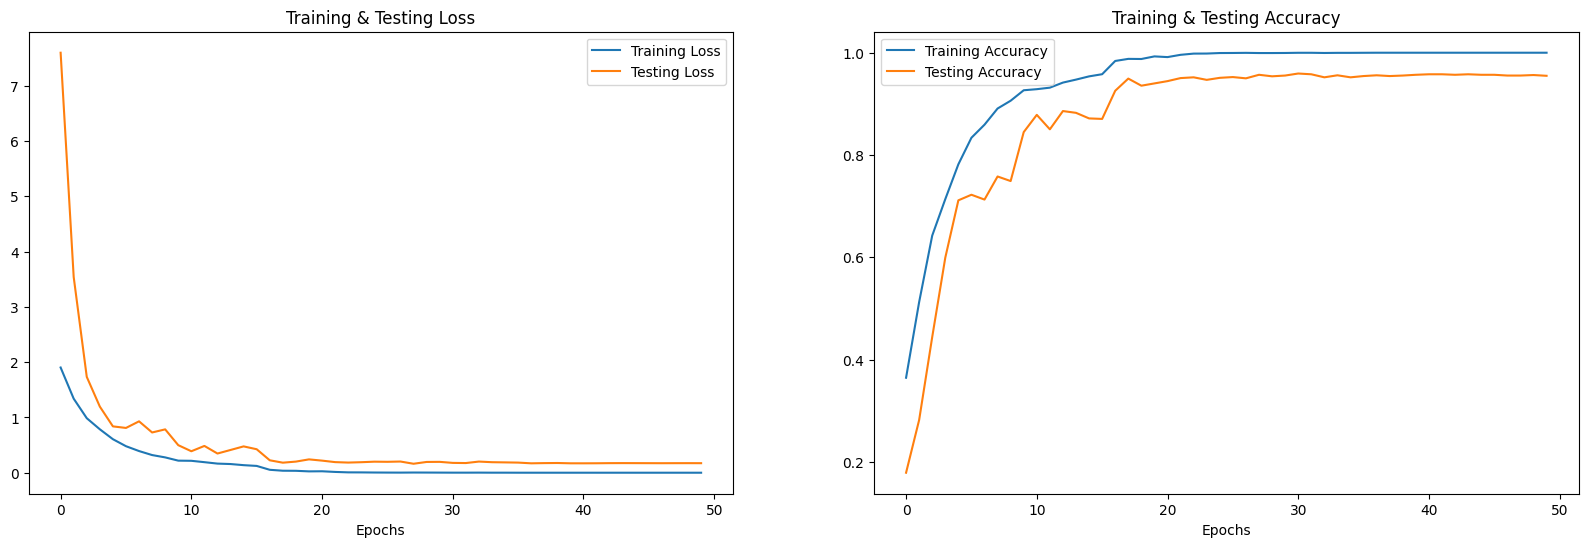

In [ ]:
print("Accuracy of our model on test data : " , round(model.evaluate(x_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()


<h2><b><font color = 'darkblue'>Save our model</b></h2>

In [ ]:
# Save model and weights
model_name = 'Emotion_Model_conv1d_gender_93.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("Emotion_Model_conv1d_gender_93.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/saved_models/Emotion_Model_conv1d_gender_93.h5 


<h2><b><font color = 'darkblue'>Loading our model</b></h2>

In [ ]:
from keras.models import model_from_json

# loading json and model architecture
json_file = open('/content/Emotion_Model_conv1d_gender_93.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/saved_models/Emotion_Model_conv1d_gender_93.h5")
print("Loaded model from disk")

# Keras optimiser
loaded_model.compile(optimizer = 'RMSprop' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))


Loaded model from disk
accuracy: 95.49%


<h2><b><font color = 'darkblue'>Model's prediction</b></h2>

In [ ]:
preds = model.predict(x_test)

63/63 [==============================] - 8s 128ms/step


In [ ]:
# predicting on test data.
y_pred = encoder.inverse_transform(preds)
y_tmp = encoder.inverse_transform(y_test)

In [ ]:
final_df = pd.DataFrame(columns=['PredictedLabels', 'ActualLabels'])
final_df['PredictedLabels'] = y_pred.flatten()
final_df['ActualLabels'] = y_tmp.flatten()

final_df

,PredictedLabels,ActualLabels
0,female_neutral,female_neutral
1,male_neutral,male_neutral
2,female_sad,female_sad
3,male_angry,male_angry
4,female_neutral,female_neutral
...,...,...
2011,male_sad,male_sad
2012,male_disgust,male_disgust
2013,female_neutral,female_neutral
2014,male_neutral,male_neutral


<h2><b><font color = 'darkblue'>Evaluating our model on emotions</b></h2>

Accuracy of our model on test data based on emotions:  96.0 %


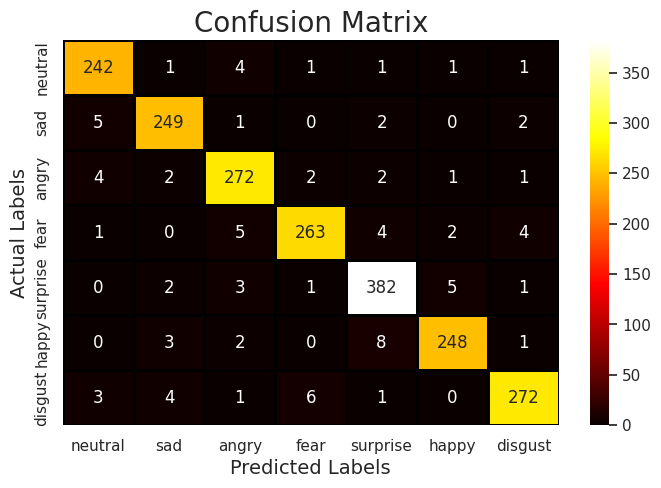

In [ ]:
modidf = final_df
modidf['ActualLabels'] = final_df.ActualLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['PredictedLabels'] = final_df.PredictedLabels.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.ActualLabels.unique()
classes.sort()

# Confusion matrix
c = confusion_matrix(modidf.ActualLabels, modidf.PredictedLabels)
print("Accuracy of our model on test data based on emotions: " ,round(accuracy_score(modidf.ActualLabels, modidf.PredictedLabels),2)*100,"%")

#cm = confusion_matrix(y_tmp, y_pred)
plt.figure(figsize = (8, 5))
c = pd.DataFrame(c , index = [i for i in modidf['ActualLabels'].unique()] , columns = [i for i in modidf['PredictedLabels'].unique()])
sns.heatmap(c, linecolor='Black', cmap='hot', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(modidf.ActualLabels, modidf.PredictedLabels))

              precision    recall  f1-score   support

       angry       0.95      0.96      0.96       251
     disgust       0.95      0.96      0.96       259
        fear       0.94      0.96      0.95       284
       happy       0.96      0.94      0.95       279
     neutral       0.95      0.97      0.96       394
         sad       0.96      0.95      0.96       262
    surprise       0.96      0.95      0.96       287

    accuracy                           0.96      2016
   macro avg       0.96      0.96      0.96      2016
weighted avg       0.96      0.96      0.96      2016

